In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
import tensorflow as tf
import numpy as np

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            #tf.config.experimental.set_per_process_memory_fraction(0.75)
            tf.config.experimental.set_memory_growth(gpu, False)
            #tf.config.gpu.set_per_process_memory_fraction(0.4)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 1
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './dataset/VOCdevkit_train/VOC2007/pascal_voc_training_data.txt'
IMAGE_DIR = './dataset/VOCdevkit_train/VOC2007/JPEGImages/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-4
EPOCHS = 3

classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, InputLayer, Dropout, LayerNormalization, Flatten, Dense, LeakyReLU

In [5]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
#x = conv_leaky_relu(img_inputs, 64, 7, 2)
x = Conv2D(64, activation='relu', padding='same', kernel_size=(3, 3), strides=(1, 1))(img_inputs)
x = Conv2D(64, activation='relu', padding='same', kernel_size=(3, 3), strides=(1, 1))(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same', strides=(2, 2))(x)

x = Conv2D(128, data_format="channels_last",  activation='relu', 
       padding='same', kernel_size=(3, 3), strides=(1, 1))(x)
x = Conv2D(128, data_format="channels_last",  activation='relu', 
       padding='same', kernel_size=(3, 3), strides=(1, 1))(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same', strides=(2, 2))(x)

x = Conv2D(256, data_format="channels_last",  activation='relu',
       padding='same', kernel_size=(3, 3), strides=(1, 1))(x)
x = Conv2D(256, data_format="channels_last",  activation='relu',
       padding='same', kernel_size=(3, 3), strides=(1, 1))(x)
x = Conv2D(256, data_format="channels_last",  activation='relu',
       padding='same', kernel_size=(3, 3), strides=(1, 1))(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same', strides=(2, 2))(x)

x = Conv2D(512, data_format="channels_last",  activation='relu',
       padding='same', kernel_size=(3, 3), strides=(1, 1))(x)
x = Conv2D(512, data_format="channels_last",  activation='relu',
       padding='same', kernel_size=(3, 3), strides=(1, 1))(x)
x = Conv2D(512, data_format="channels_last",  activation='relu',
       padding='same', kernel_size=(3, 3), strides=(1, 1))(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same', strides=(2, 2))(x)

x = Conv2D(512, data_format="channels_last",  activation='relu',
       padding='same', kernel_size=(3, 3), strides=(1, 1))(x)
x = Conv2D(512, data_format="channels_last",  activation='relu',
       padding='same', kernel_size=(3, 3), strides=(1, 1))(x)
x = Conv2D(512, data_format="channels_last",  activation='relu',
       padding='same', kernel_size=(3, 3), strides=(1, 1))(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same', strides=(2, 2))(x)

#x = Dropout(0.25)(x)
x = Conv2D(125, use_bias=True, data_format="channels_last", activation='relu',
       padding='same', kernel_size=(1, 1), strides=(1, 1), kernel_initializer='random_uniform')(x)
x = Flatten()(x)
x = Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = LeakyReLU(0.1)(x)
outputs = Dense(1470, activation='relu', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")

In [6]:
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore('./ckpts/YOLO/yolo-37')

In [7]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bou
    """

    n1 = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    n2 = n1 + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:n1], (-1, 7, 7, 20))
    scales = np.reshape(outputs[:, n1:n2], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, n2:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, scales, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]
    #print P[5,1, 0, :]

    #choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                             CELL_SIZE,
                             BOXES_PER_CELL, 
                             4))

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    xmin = xcenter - w/2.0
    ymin = ycenter - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf

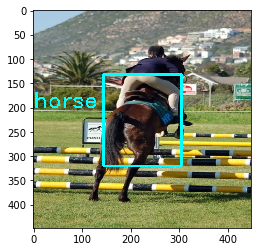

In [8]:
np_img = cv2.imread('./dataset/VOCdevkit_test/VOC2007/JPEGImages/000010.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = YOLO(np_img)
xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred)
class_name = classes_name[class_num]
cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.imshow(resized_img)
plt.show()